In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.compose import ColumnTransformer
import random

In [7]:
df = pd.read_csv('./X_train.csv')

In [8]:
df.columns

Index(['t', 'x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2',
       'x_3', 'y_3', 'v_x_3', 'v_y_3', 'Id'],
      dtype='object')

In [9]:
idx = np.hstack((0,df[df.t == 10].index.values + 1))
idx.shape, df.t.min(), df.t.max()
idx

array([      0,     257,     514, ..., 1284486, 1284743, 1285000],
      shape=(4054,))

In [10]:
def baseline_split(validation_percentage, test_percentage):
    data = df.drop(columns = ['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3', 'Id'])

    random.seed(42)
    case_times = 257
    trajectories = [df.iloc[i:i + case_times] for i in range(0, len(data), case_times)]

    x, y, x_train, y_train, x_validation, y_validation, x_test, y_test = [], [], [], [], [], [], [], []
    t = trajectories[0][["t"]].values

    for traj in trajectories:
        traj = traj.drop_duplicates()

        first_pos = traj[0:1].drop(columns=["t"])

        aux = pd.concat([first_pos] * len(traj), ignore_index=True)
        aux['t'] = t[0:len(traj)]

        x.append(aux)
        y.append(traj)

        r = random.random()
        if r < test_percentage:
            x_test.append(aux)
            y_test.append(traj)
        elif r < test_percentage + validation_percentage:
            x_validation.append(aux)
            y_validation.append(traj)
        else:
            x_train.append(aux)
            y_train.append(traj)

    return x_train, y_train, x_validation, y_validation, x_test, y_test

In [11]:
x_train, y_train, x_validation, y_validation, x_test, y_test = baseline_split(0.2, 0.2)

In [12]:
x_train_flat = np.concatenate(x_train)
y_train_flat = np.concatenate(y_train)
x_val_flat = np.concatenate(x_validation)
y_val_flat = np.concatenate(y_validation)

baseline_regressor = make_pipeline(StandardScaler(), LinearRegression())
baseline_regressor.fit(x_train_flat, y_train_flat)
baseline_y_hat = baseline_regressor.predict(x_val_flat)
baseline_rmse = mean_squared_error(y_val_flat, baseline_y_hat)
baseline_rmse

1.3047099082274003

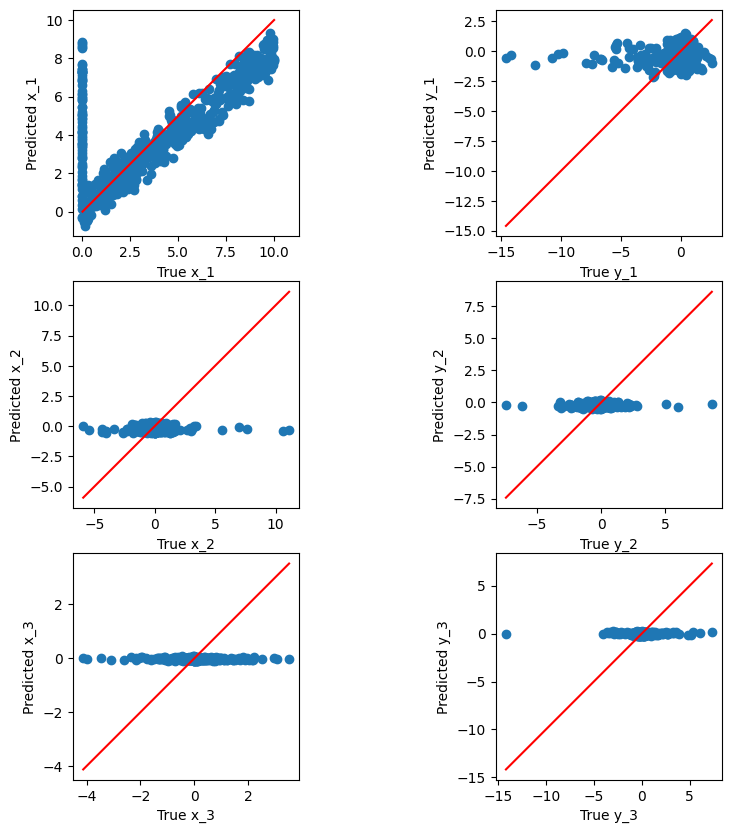

In [13]:
x_test_flat = np.concatenate(x_test)
y_test_flat = np.concatenate(y_test)

def plot_y_yhat(y_test,y_pred, plot_title = "plot"):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_test) > MAX:
        idx = np.random.choice(len(y_test),MAX, replace=False)
    else:
        idx = np.arange(len(y_test))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_test[idx,i])
        x1 = np.max(y_test[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_test[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.savefig(plot_title+'.pdf')
    plt.show()

plot_y_yhat(y_test_flat,baseline_y_hat)